# Word2Vec (PyTorch Guide)

Word2Vec is a set of techniques for representing words as numerical vectors.  
These vectors are positioned in a high-dimensional space so that **similar words are close together**.  
These vectors are called **word embeddings**.

For example:  
- Words like *"king"* and *"queen"* will have vectors near each other.  
- A word like *"book"* will be positioned farther away.  
- Even simple vector arithmetic works, e.g., **king − man + woman ≈ queen**.  

This representation allows machine learning models to capture **semantic relationships** between words.

## Setup

### Step 1: Familiarize with training data.

In this notebook, we use 100 sentences i scraped from redit about ML. 

In [1]:
import pandas as pd

df = pd.read_csv("../../datasets/ML_Sentences.csv")

print(df.head())

                                            sentence
0               We Make computer understand patterns
1               Learning machines reshape our future
2  Recurrent neural networks handle sequential da...
3  Regularization techniques help prevent overfit...
4  Hyperparameter tuning significantly affects mo...


### Step 2: Build the vocabulary. 

In [12]:
# load a simple tokenizer
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer("basic_english")

# the data must be an iterable of strings
def tokenize(sentences):
    for s in sentences:
        yield tokenizer(s)
sentences = df["sentence"].astype(str).tolist()
tokenized_data = tokenize(sentences)

# build vocabulary 
from torchtext.vocab import build_vocab_from_iterator
vocab = build_vocab_from_iterator(tokenized_data, specials=['unk'])
vocab.set_default_index(vocab["unk"])

# demonstration
sample = "Learning machines reshape our future" 
tokens = tokenizer(sample)
print(tokens)

# you can write a function to translate tokens via vocab into numbers
text_pipeline = lambda tokens:[vocab[token] for token in tokens]
print(text_pipeline(tokens))

['learning', 'machines', 'reshape', 'our', 'future']
[9, 10, 22, 15, 5]


## Continuous Bag of Words (CBOW)

The **Continuous Bag of Words (CBOW)** model predicts a **target word** from a fixed-size **context window** of surrounding words. The context consists of the words that appear before and after the target.

**Example:**  
Sentence:  
`I wish I were an ML expert`  

With a **context window size of 2**, the context for predicting `I` is:  `["I", "wish", "were", "an"]`.

**Training Data:**  
The training data is structured as pairs **(x, y)**, where:  
- **x** is the input context: $(w_{t-2}, w_{t-1}, w_{t+1}, w_{t+2})$
- **y** is the target word to predict: $w_t$

The model learns to estimate:  
$$
P(w_t \mid w_{t-2}, w_{t-1}, w_{t+1}, w_{t+2})
$$

In [3]:
CONTEXT_WINDOW = 2

def setup_training_data(tokenized_sentences):
    training_data = []
    for s in tokenized_sentences:
        for i in range(CONTEXT_WINDOW, len(s) - CONTEXT_WINDOW):
            wtm2, wtm1 = s[i-2], s[i-1]
            wta1, wta2 = s[i+1], s[i+2]
            y = s[i]
            training_data.append(((wtm2, wtm1, wta1, wta2), y))
    return training_data

# Demonstration
training_data = setup_training_data(tokenize(sentences))
print(training_data[:5])

[(('we', 'make', 'understand', 'patterns'), 'computer'), (('learning', 'machines', 'our', 'future'), 'reshape'), (('recurrent', 'neural', 'handle', 'sequential'), 'networks'), (('neural', 'networks', 'sequential', 'data'), 'handle'), (('networks', 'handle', 'data', 'such'), 'sequential')]


The `collate_batch` function prepares training batches by converting each `(context, target)` pair into numerical representations using the vocabulary.  
The function should return **two tensors**:  
- A **context tensor** of shape `(batch_size, context_window * 2)`  
- A **target tensor** of shape `(batch_size)`  

In [23]:
import torch

# Device for training: use GPU (CUDA) if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    context_list, target_list = [], []
    for context, target in batch:
        context_list.append(text_pipeline(list(context)))
        target_list.append(vocab[target])

    context_tensor = torch.tensor(context_list,dtype=torch.int64).to(device)
    target_tensor = torch.tensor(target_list, dtype=torch.int64).to(device)
    
    return context_tensor, target_tensor

# Demonstration
context_tensor, target_tensor = collate_batch(training_data[:5])
print(context_tensor, target_tensor)

def decode_context(tensor):
    return [[vocab.lookup_token(idx) for idx in context] for context in tensor]

print(decode_context(context_tensor))

tensor([[30, 11, 29, 17],
        [ 9, 10, 15,  5],
        [20, 14,  6, 23],
        [14, 13, 23,  4],
        [13,  6,  4, 25]]) tensor([ 3, 22, 13,  6, 23])
[['we', 'make', 'understand', 'patterns'], ['learning', 'machines', 'our', 'future'], ['recurrent', 'neural', 'handle', 'sequential'], ['neural', 'networks', 'sequential', 'data'], ['networks', 'handle', 'data', 'such']]


The `DataLoader` takes care of batching. Instead of feeding all training samples at once, it groups them into mini-batches of size `BATCH_SIZE = 32`.  

We batch for three key reasons:  

1. **Efficiency**: Neural networks run much faster when samples are processed in parallel. Batches make this possible by enabling efficient matrix operations.  
2. **Stability**: Updating weights after every single sample makes gradients noisy and unstable. Batches average gradients across samples, smoothing training.  
3. **Memory constraints**: You can’t usually train on the whole dataset at once — many datasets don’t fit in memory. Mini-batches let us train piece by piece.  

In [24]:
from torch.utils.data import DataLoader

BATCH_SIZE = 12

cbow_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

print(cbow_dataloader)

#### Building a CBOW model in PyTorch (window size = 2)

We’ll implement **CBOW** (Continuous Bag of Words) using PyTorch’s `nn` modules.

**Step 1: Embedding Layer**

With a context window of **2**, each training example has **4 context tokens**. However, instead of feeding **four one-hot vectors of size `vocab_size`** (which would be huge), we use an **embedding layer**. Each word (e.g., "machine" → 4 → [0,0,0,1,0,...,0]) is mapped to a dense embedding vector of the size `EMBED_DIM=24` (e.g., [0,0,0,1,0,...,0]) → [0.12,0.4,...,0.31]). We achieve this with `nn.Embedding(vocab_size, embed_dim)`. Internally, PyTorch creates a **matrix of learnable weights** that functions as a trainable dictionary:  
- Each row corresponds to one word in the vocabulary.  
- Looking up a token ID retrieves its embedding vector.  
- During training, backpropagation updates the rows for the words that appear in the batch, so words used in similar contexts will gradually learn similar vectors.  

We first map each token ID to an embedding vector and then **aggregate** the 4 vectors into **one context representation** using the **mean**. That single vector goes into the next (linear) layer to predict the target word.

**Step 2: Linear Layer**

- Purpose: **reduce the dimensionality** of the embedding vector.  
- Example: if `EMBED_DIM = 24`, we reduce to `EMBED_DIM//2 = 12`.  
- The model must keep the *most useful* features, this bottleneck **counteracts overfitting**.

**Step 3: Fully Connected (FC) Layer (Output Layer)**

The output dimension must equal `vocab_size` so that we can assing a probability to every word in our voacbularly. We can assign this probabilities by applying the `softmax` function, that turns a vector of logits $z = [z_1, z_2, \dots, z_n]$ into a **probability distribution** (all values are between 0 and 1).

$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}
$$

In [25]:
import torch.nn as nn

class CBOW(nn.Module):
    # Initialize the CBOW model:
    def __init__(self, vocab_size, embed_dim):
        super(CBOW, self).__init__()
        # Define the embedding layer using nn.EmbeddingBag (mode='mean' is default)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # Define the linear layer
        self.linear = nn.Linear(embed_dim, embed_dim//2)
        # Define the fully connected layer (output layer)
        self.fc = nn.Linear(embed_dim//2,vocab_size)

        self.init_weights()

    # Initialize the model's parameters with random weights
    def init_weights(self):
        # [-0.5,0.5] is a simple, safe and symmetric range that is often used
        initrange = 5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)

    def forward(self, context_ids):
        # Pass the input through the embedding layer
        out = self.embedding(context_ids)
        out = out.mean(dim=1)
        # Pass the result through the linear layer using the ReLU activation function
        # Note: Without the ReLU activation function, the layers would just collapse into one. 
        out = torch.relu(self.linear(out))
        # Pass the result through the fc layer 
        out = self.fc(out)
        return out

vocab_size = len(vocab)
EMBED_DIM = 10
cbow_model = CBOW(vocab_size, EMBED_DIM).to(device)
print(cbow_model)

CBOW(
  (embedding): Embedding(31, 10)
  (linear): Linear(in_features=10, out_features=5, bias=True)
  (fc): Linear(in_features=5, out_features=31, bias=True)
)


### Train the model

To train the model, we define a function `train_model` that handles the **training loop**. It takes as input:
- `model`: PyTorch Model
- `dataloader`: Batches the training data.
- `num_epochs`: How many times to go through the entire dataset.
We will collect the average loss of each epoch in `epoch_losses`, to plot how less decreases over time.

100%|████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2662.12it/s]


Text(0.5, 0, 'epochs')

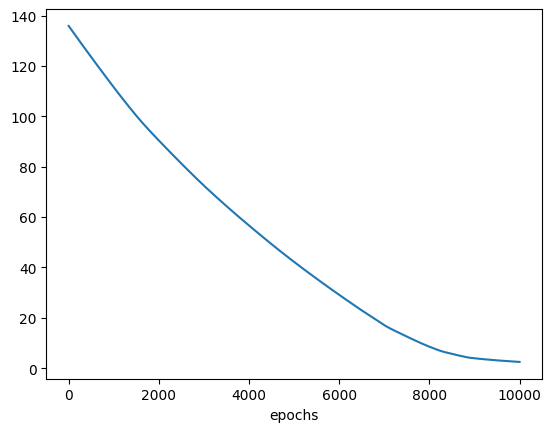

In [26]:
from copy import deepcopy
from tqdm import tqdm

def train_model(model, dataloader, loss_fn = nn.CrossEntropyLoss(), num_epochs=10_000):
    epoch_losses = []
    best_loss = float('inf')
    best_model = None

    # SGD optimizes/updates the parameters of the model; lr (learning rate)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    
    # training loop; tqdm adds a nice progress bar in the console
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0

        for batch in dataloader:
            context, target = batch
            predicted = model(context)
            # calculate the loss
            loss = loss_fn(predicted, target)
            running_loss += loss.item()
            # performs backprogpagation → now each parameter p has p.grad filled
            loss.backward()
            # common regularization technique
            # looks at all p.grad and scales down the gradients proportionally (typical values are 0.1,1,5,10)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # uses p.grad to update the parameters p
            optimizer.step()

            # save model state if this epoch is the best so far
            if running_loss < best_loss:
                best_loss = running_loss
                best_model = deepcopy(model.state_dict())

        epoch_losses.append(running_loss/len(dataloader))

    # load best model
    model.load_state_dict(best_model)
    
    return model, epoch_losses

model, epoch_losses = train_model(cbow_model, cbow_dataloader)

# plot loss values
import matplotlib.pyplot as plt
plt.plot(epoch_losses)
plt.xlabel("epochs")

In [29]:
tokens = tokenizer("learning machines our future")
context_ids = torch.tensor([text_pipeline(tokens)], dtype=torch.int64).to(device)
print(context_ids)
logits = model(context_ids)
print(logits)
predicted_id = logits.argmax(dim=1).item()
print(predicted_id)
predicted_word = vocab.lookup_token(predicted_id)
print(predicted_word)

tensor([[ 9, 10, 15,  5]])
tensor([[  9.4394, -38.6749,   8.1475, -20.5259, -21.8952, -11.2417,  19.8635,
         -24.7578,  19.6236,   5.4301,   6.4518,  -6.7533,  18.5886, -10.1005,
           0.7683, -17.1970,  21.3609,   2.0149,  11.8496, -12.6517,  22.0720,
         -13.1533,  24.3072,   4.9149,   4.8908,  17.6028, -30.2242,  13.3671,
          15.5109, -21.7701,  -8.2020]], grad_fn=<AddmmBackward0>)
22
reshape
